In [ ]:
# from nilm_metadata import get_appliance_types
# appliance_types = get_appliance_types()
# print(appliance_types)

# import os
# os.getcwd()

## Carregando bibliotecas...

In [1]:
!pip install seaborn

import seaborn as sns

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import nilmtk
from nilmtk import MeterGroup
from nilmtk.api import API
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
rcParams['figure.figsize'] = (13, 10)

# import pathlib
# pathlib.Path().resolve()

## Converter

In [2]:
# from nilmtk.dataset_converters import convert_hb
# convert_hb('./BD/CASA/convert', './data/teste17.h5')

In [3]:
# st = pd.HDFStore("./data/teste17.h5")
# print (st.keys())

# print (st['/building1/elec/meter1'].head())
# print (st['/building1/elec/meter2'].head())
# print (st['/building1/elec/meter3'].head())

# st.close()

## Carregando dataset

In [4]:
from nilmtk.api import API
import warnings
warnings.filterwarnings("ignore")

from nilmtk import DataSet
from nilmtk.utils import print_dict

#hb = DataSet('teste17.h5') # ventilador e microondas
# hb = DataSet('convert_ar_lav.h5') # ar e lava roupas
hb = DataSet('convert_ar_lav_utc5.h5') # ar e lava roupas
# redd = DataSet('redd.h5')

#iawe = DataSet('/data/iawe.h5')

print_dict(hb.metadata)
print_dict(hb.buildings)

# Espectrograma

Teniendo en cuenta sólo en consumo agregado, podemos realizar esta especie de espectograma donde el eje-y es el día de la semana y el eje-x la hora del día. De esta forma, obtener información valiosa de cuando hay una mayor actividad en la casa

Levando em conta apenas o consumo agregado, podemos fazer esse tipo de espectrograma onde o eixo y é o dia da semana e o eixo x é a hora do dia. Dessa forma, obtenha informações valiosas sobre quando há uma maior atividade na casa

https://github.com/josemao/nilmtk_practicas/blob/master/3%20-%20Estudio%20previo%20a%20la%20desagregacion%20(busqueda%20de%20patrones)%20(solucion).ipynb

In [5]:
hb.buildings[1].elec.power_series_all_data()

Loading data for meter ElecMeterID(instance=3, building=1, dataset='HB')     
Done loading data all meters for this chunk.


2021-12-07 19:40:10-03:00     914.400024
2021-12-07 19:40:15-03:00    1370.045044
2021-12-07 19:40:20-03:00    1369.598999
2021-12-07 19:40:25-03:00    1368.818970
2021-12-07 19:40:30-03:00    1368.677979
                                ...     
2021-12-21 22:54:00-03:00     416.260010
2021-12-21 22:54:05-03:00     416.139984
2021-12-21 22:54:10-03:00     416.320007
2021-12-21 22:54:15-03:00     416.039978
2021-12-21 22:54:20-03:00     416.100006
Freq: 5S, Name: (power, active), Length: 244251, dtype: float32

Loading data for meter ElecMeterID(instance=3, building=1, dataset='HB')     
Done loading data all meters for this chunk.
                                 power
                                active
2021-12-07 19:30:00-03:00  1316.247314
2021-12-07 20:00:00-03:00  1169.833618
2021-12-07 20:30:00-03:00  1148.769897
2021-12-07 21:00:00-03:00  1067.955078
2021-12-07 21:30:00-03:00   938.222839
...                                ...
2021-12-21 20:30:00-03:00   782.862305
2021-12-21 21:00:00-03:00   660.876282
2021-12-21 21:30:00-03:00   581.597290
2021-12-21 22:00:00-03:00  1727.098999
2021-12-21 22:30:00-03:00   953.704468

[679 rows x 1 columns]


[Text(0, 0, 'Segunda'),
 Text(0, 0, 'Terça'),
 Text(0, 0, 'Quarta'),
 Text(0, 0, 'Quinta'),
 Text(0, 0, 'Sexta'),
 Text(0, 0, 'Sabado'),
 Text(0, 0, 'Domingo')]

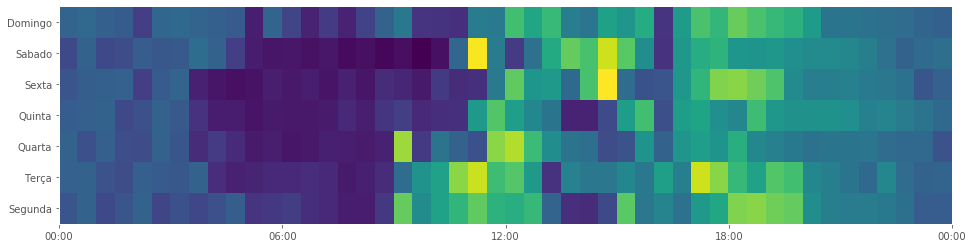

In [8]:
import numpy as np
df=hb.buildings[1].elec.power_series_all_data(sample_period=60*30).to_frame()
print(df)
df.fillna(0,inplace=True)
df.columns=['active']
df['weekday']=df.index.weekday
df['time']=df.index.time
matrix=df.groupby(['weekday','time']).active.mean().unstack().values
plt.figure(figsize=(16, 4))
ax = plt.gca()
plt.pcolor(matrix)
plt.xlim([0,48])
ax.set_xticks(np.arange(0,49,12))
ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])
ax.set_yticks(np.arange(0.5,7))
ax.set_yticklabels(['Segunda','Terça','Quarta','Quinta','Sexta','Sabado','Domingo'])

Olhado para o espectograma da potência ativa do quadro geral, visualmente é possível identificar padrões no uso da energia. Como os dados foram capturados em uma residência durante o periodo de pandemia e os residentes estavam trabalhando em home office, o padrão é um pouco irregular, mas fica claro que as atividades são distribuídas durante o dia, 


Casa 2 (padrão irregular): Atividade média-alta muito distribuída durante a noite. Possível distúrbio do sono. Atividade também distribuída durante o dia, possivelmente trabalhando em casa. 

Casa 3 (padrão regular): Baixa atividade nas tardes de sexta e sábado. Inicia a sua actividade em média à mesma hora do dia de segunda a sexta-feira 

Casa 4 (padrão irregular): Actividade média-alta durante a noite excepto sexta, sábado e domingo. Ele provavelmente passa muitos fins de semana fora de casa. Atividade distribuída durante o dia. 

Casa 5 (padrão anormal): Possivelmente os dados não foram coletados adequadamente. 

Casa 6 (padrão regular): Alta atividade a partir das 18h, exceto aos sábados, onde a atividade se movimenta à noite. Terça e quinta à noite alta atividade à noite. Possível rotina de trabalho noturno.

# Patrones de uso

In [6]:
elecs=hb.buildings[1].elec
elecs


MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='HB', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='HB', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=3, building=1, dataset='HB', appliances=[Appliance(type='air conditioner', instance=1)])
)

Escolhemos um dispositivo, extraímos o dataframe com seu consumo e rotulamos por horas.

In [15]:
elecs=hb.buildings[1].elec
elecs

# elec=elecs['air conditioner'] #'washer dryer'
elec=elecs['washer dryer'] #'washer dryer'

elec
df=next(elec.load())
columns = [''.join(col).strip() for col in df.columns.values]
df.columns=columns
df['hour']=df.index.hour
df.head()

,powerapparent,voltage,poweractive,power factor,current,powerreactive,hour
2021-12-07 19:40:17-03:00,0.0,219.906998,0.0,0.0,0.0,0.0,19
2021-12-07 19:40:22-03:00,0.0,219.145996,0.0,0.0,0.0,0.0,19
2021-12-07 19:40:27-03:00,0.0,219.145996,0.0,0.0,0.0,0.0,19
2021-12-07 19:40:32-03:00,0.0,219.145996,0.0,0.0,0.0,0.0,19
2021-12-07 19:40:37-03:00,0.0,219.145996,0.0,0.0,0.0,0.0,19


Agrupamos a potência ativa por horas somando e dividindo pela potência ativa total.

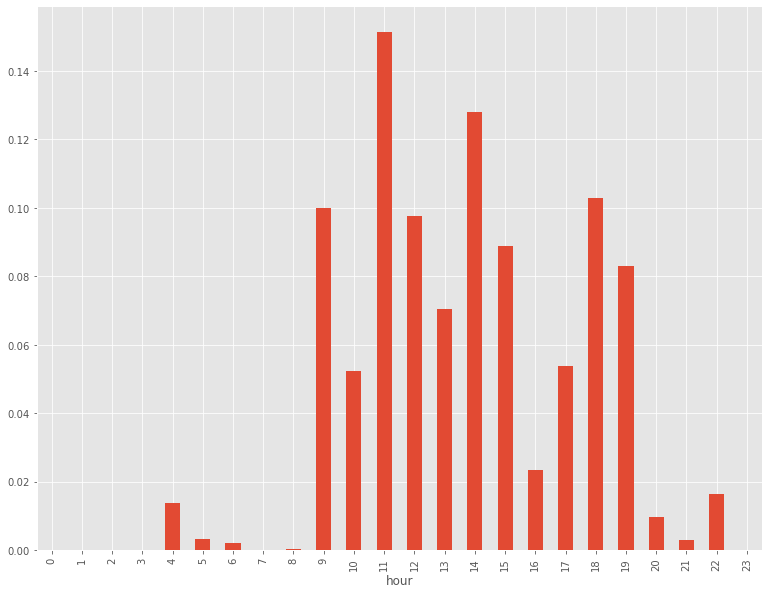

In [16]:
pattern=df.groupby('hour').sum()[columns[2]]/df[columns[2]].sum()
pattern.plot(kind='bar')


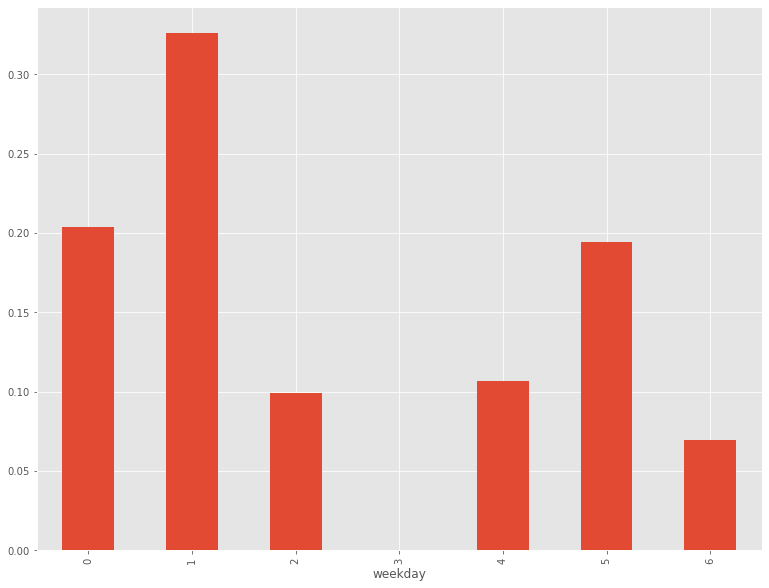

In [17]:
df['weekday']=df.index.weekday
pattern=df.groupby('weekday').sum()[columns[2]]/df[columns[2]].sum()
pattern.plot(kind='bar')

**Imprimir** mínimo y máximo de datetime y la diferencia de ambos

In [18]:
print(df['Time'].min())
print(df['Time'].max())
print (df['Time'].max()-df['Time'].min())


KeyError: 'Time'

https://github.com/nilmtk/nilmtk/blob/303d45bf6c39b44d76c35e8aaa690cef6af8ae38/nilmtk/electric.py#L780

In [25]:
import numpy as np
# Ar: 15, 15, 10
# Lav: 15, 15, 5
elec=elecs['washer dryer'] #'washer dryer'
df2=next(elec.load())

activ = get_activations(df2, 15, 15, 1, 10)
activ

ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'

In [19]:
def get_activations(chunk, min_off_duration=0, min_on_duration=0, border=1, on_power_threshold=5):
    """Returns runs of an appliance.
    Most appliances spend a lot of their time off.  This function finds
    periods when the appliance is on.
    Parameters
    ----------
    chunk : pd.Series
    min_off_duration : int
        If min_off_duration > 0 then ignore 'off' periods less than
        min_off_duration seconds of sub-threshold power consumption
        (e.g. a washing machine might draw no power for a short
        period while the clothes soak.)  Defaults to 0.
    min_on_duration : int
        Any activation lasting less seconds than min_on_duration will be
        ignored.  Defaults to 0.
    border : int
        Number of rows to include before and after the detected activation
    on_power_threshold : int or float
        Watts
    Returns
    -------
    list of pd.Series.  Each series contains one activation.
    """
    when_on = chunk >= on_power_threshold

    # Find state changes
    state_changes = when_on.astype(np.int8).diff()
    del when_on
    switch_on_events = np.where(state_changes == 1)[0]
    switch_off_events = np.where(state_changes == -1)[0]
    del state_changes

    if len(switch_on_events) == 0 or len(switch_off_events) == 0:
        return []

    # Certifique-se de que os eventos estejam alinhados
    if switch_off_events[0] < switch_on_events[0]:
        switch_off_events = switch_off_events[1:]
        if len(switch_off_events) == 0:
            return []
    if switch_on_events[-1] > switch_off_events[-1]:
        switch_on_events = switch_on_events[:-1]
        if len(switch_on_events) == 0:
            return []
    assert len(switch_on_events) == len(switch_off_events)

    # Smooth over off-durations less than min_off_duration
    if min_off_duration > 0:
        off_durations = (chunk.index[switch_on_events[1:]].values -
                         chunk.index[switch_off_events[:-1]].values)

        off_durations = timedelta64_to_secs(off_durations)

        above_threshold_off_durations = np.where(
            off_durations >= min_off_duration)[0]

        # Now remove off_events and on_events
        switch_off_events = switch_off_events[
            np.concatenate([above_threshold_off_durations,
                            [len(switch_off_events)-1]])]
        switch_on_events = switch_on_events[
            np.concatenate([[0], above_threshold_off_durations+1])]
    assert len(switch_on_events) == len(switch_off_events)

    activations = []
    for on, off in zip(switch_on_events, switch_off_events):
        duration = (chunk.index[off] - chunk.index[on]).total_seconds()
        if duration < min_on_duration:
            continue
        on -= 1 + border
        if on < 0:
            on = 0
        off += border
        activation = chunk.iloc[on:off]
        # throw away any activation with any NaN values
        if not activation.isnull().values.any():
            activations.append(activation)

    return activations

## Gráfico Geral

In [4]:
build = 1
elec = hb.buildings[build].elec
elec.mains().power_series_all_data().head()

2021-12-07 19:40:13-03:00    914.400024
2021-12-07 19:40:14-03:00    914.400024
2021-12-07 19:40:15-03:00    913.299988
2021-12-07 19:40:16-03:00    916.700012
2021-12-07 19:40:17-03:00    910.500000
Name: (power, active), dtype: float32

In [14]:
elec['washer dryer'].dominant_appliance().metadata


TypeError: 'ElecMeter' object is not subscriptable

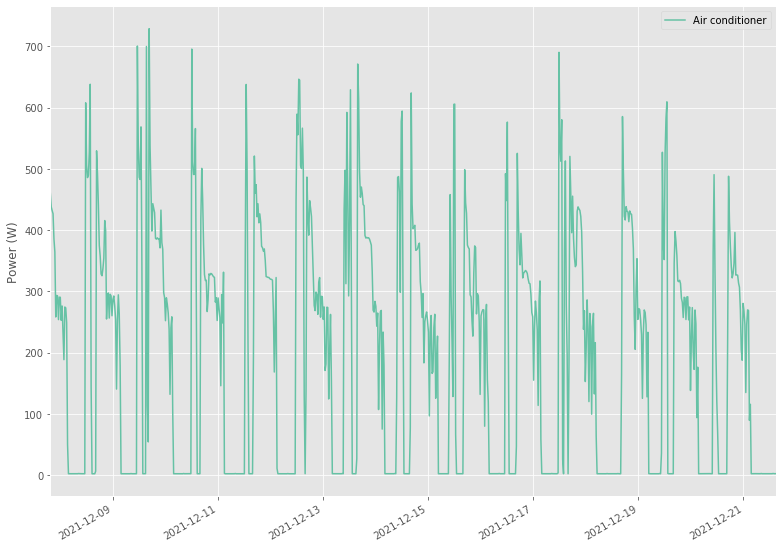

In [6]:
sns.set_palette("Set2", n_colors=5)
# elec.mains().plot()
# elec['washer dryer'].plot()
elec['air conditioner'].plot()

# Set a threshold to remove residual power noise when devices are off
# elec.plot_when_on(on_power_threshold = 40) # Plot appliances when they are in use¶

# elec.draw_wiring_graph()

## Dados

##### Proporção de energia submedida

In [ ]:
elec.proportion_of_energy_submetered()

##### Total Energy

In [ ]:
elec.mains().total_energy()

##### Energy per submeter

In [ ]:
energy_per_meter = elec.submeters().energy_per_meter() # kWh, again
energy_per_meter

#####  Plot fraction of energy consumption of each appliance

In [ ]:
# fraction = elec.submeters().fraction_per_meter().dropna()
fraction = elec.fraction_per_meter().dropna()
# Create convenient labels
labels = elec.get_labels(fraction.index)
plt.figure(figsize=(10,30))
fraction.plot(kind='pie', labels=labels);

### Quadro Geral

In [ ]:
print(elec)
elec.mains()

In [ ]:
from nilmtk.elecmeter import ElecMeterID##### Quadro Geral

meter1 = elec[ElecMeterID(instance=1, building=build, dataset='HB')]

next(meter1.load()).tail()

In [ ]:
meter1.plot()

A taxa de abandono é um número entre 0 e 1 que especifica a proporção de amostras ausentes. Uma taxa de abandono de 0 significa que nenhuma amostra está faltando. Um valor de 1 significaria que todas as amostras estão faltando

In [ ]:
meter1.dropout_rate()

In [ ]:
good_sections = meter1.good_sections(full_results=True)
good_sections.plot()

In [ ]:
good_sections.combined()

##### Microondas

In [ ]:
air_conditioner= elec['air conditioner']

#microwave.available_columns()
next(air_conditioner.load()).head()

In [ ]:
air_conditioner.plot()


A taxa de abandono é um número entre 0 e 1 que especifica a proporção de amostras ausentes. Uma taxa de abandono de 0 significa que nenhuma amostra está faltando. Um valor de 1 significaria que todas as amostras estão faltando

In [ ]:
air_conditioner.dropout_rate()

In [ ]:
good_sections = air_conditioner.good_sections(full_results=True)
good_sections.plot()

In [ ]:
good_sections.combined()

##### Ventilador

In [ ]:
washer_dryer= elec['washer dryer']
#microwave.available_columns()
next(washer_dryer.load()).head()

In [ ]:
washer_dryer.plot()

In [ ]:
good_sections = washer_dryer.good_sections(full_results=True)
good_sections.plot()

A taxa de abandono é um número entre 0 e 1 que especifica a proporção de amostras ausentes. Uma taxa de abandono de 0 significa que nenhuma amostra está faltando. Um valor de 1 significaria que todas as amostras estão faltando

In [ ]:
washer_dryer.dropout_rate()

In [ ]:
good_sections.combined()

###  Autocorrelation Plot

In [ ]:
# from pandas.plotting import autocorrelation_plot
# elec.mains().plot_autocorrelation();

### Dataframe de correlação dos aparelhos

In [ ]:
# correlation_df = elec.pairwise_correlation()
# correlation_df

### Traçar dados submedidos em um 1 dia

In [ ]:
# [TimeFrame(start='2021-12-07 19:40:13-03:00', end='2021-12-08 18:26:48-03:00', empty=False),
#  TimeFrame(start='2021-12-08 18:27:31-03:00', end='2021-12-10 13:44:05-03:00', empty=False),
#  TimeFrame(start='2021-12-10 13:44:40-03:00', end='2021-12-12 04:49:10-03:00', empty=False),
#  TimeFrame(start='2021-12-12 04:50:07-03:00', end='2021-12-21 22:54:22-03:00', empty=False)]

hb.set_window(start='2021-12-08 18:19:00', end='2021-12-08 18:28:00')

elec.plot();
plt.xlabel("Time");

In [ ]:
# hb.set_window(start='2021-09-05 00:00:00', end='2021-09-06 23:59:59')
hb.set_window(start='2021-09-05', end='2021-09-07')

# elec['microwave'].plot()
elec['fan'].plot()
plt.xlabel("Time");

Importamos os algoritmos que desejamos executar os experimentos:

Mean: Mean Algorithm

Hart's Algorithm

CO: Combinatorial Optimization

Discriminative Sparse Coding

Additive Factorial Hidden Markov Model

Additive Factorial Hidden Markov Model with Signal Aggregate Constraints

DSC: Discriminative Sparse Coding

RNN: Long short-term memory - LSTM

DAE: Denoising Auto Encoder

Seq2Point*

Seq2Seq

WindowGRU/Online GRU: Similar a LSTM, mas usa Gated Recurrent Unit (GRU)

ELM

In [3]:
from nilmtk.disaggregate import Mean,CO,Hart85
# from nilmtk_contrib.disaggregate import AFHMM,AFHMM_SAC,DSC,RNN,Seq2Point,Seq2Seq,DAE,WindowGRU
from nilmtk_contrib.disaggregate import RNN,Seq2Point,Seq2Seq,WindowGRU

Using TensorFlow backend.


Em seguida, inserimos os valores para os diferentes parâmetros no dicionário. Como precisamos de vários aparelhos, inserimos os nomes de todos os aparelhos necessários no parâmetro 'appliances'.

Métricas: https://github.com/nilmtk/nilmtk/blob/master/nilmtk/losses.py

Error: https://github.com/nilmtk/nilmtk-contrib/issues/56

In [8]:
d = {
  'power': {
    'mains': ['active',],
    'appliance': ['active']  
#     'mains': ['active', 'frequency', 'power factor', 'current', 'voltage'],
#     'appliance': ['active', 'apparent', 'reactive', 'power factor', 'current', 'voltage']
  },
  'artificial_aggregate': False,
  'sample_rate': 5,
  'display_predictions': True,
  'appliances': ['washer dryer', 'air conditioner'],
  'methods': {
      'Mean':Mean({}),
      #'CO':CO({}),
      'Hart85':Hart85({}),
      'RNN':RNN({'n_epochs':50,'batch_size':1024}),
      'Seq2Point':Seq2Point({'n_epochs':50,'batch_size':1024}),
      #'Seq2Seq':Seq2Seq({'n_epochs':50,'batch_size':1024}),
      #'WindowGRU':WindowGRU({'n_epochs':2,'batch_size':1024})
  },
 'train': {
    'datasets': {
      'hb': {
        'path': 'convert_ar_lav_utc5.h5',
        'buildings': {
              1: {
                'start_time': '2021-12-07',
                'end_time': '2021-12-17'
              },
#               2: {
#                 'start_time': '2011-04-18',
#                 'end_time': '2011-05-02'
#               },
#               3: {
#                 'start_time': '2011-04-16',
#                 'end_time': '2011-05-30'
#               },          
        }
      },
        
    }
  },
    
  'test': {
    'datasets': {
      'hb': {
        'path': 'convert_ar_lav_utc5.h5',
        'buildings': {
              1: {
                    'start_time': '2021-12-18',
                    'end_time': '2021-12-22'
          }
        }
      }
    },
    'metrics':['rmse', 'mae', 'relative_error', 'r2score', 'nde', 'nep', 'f1score']
  }
}

raiz do erro quadrático médio (RMSE) e o erro médio absoluto (MAE)

Quanto menor o seu valor, melhor é o modelo, já que a previsão se mostra mais próxima ao valor real. Comparando as duas métricas têm se que o RMSE penaliza desvios grandes, enquanto o MAE tem pesos iguais para todos os desvios.

We can observe the prediction vs. truth graphs in the above cell. The accuracy metrics can be accessed using the following commands:

In [ ]:
api_res = API(d)

Started training for  RNN
Joint training for  RNN
............... Loading Data for training ...................
Loading data for  hb  dataset
Loading building ...  1
Dropping missing values
{'washer dryer': {'mean': 57.52668, 'std': 280.61826}, 'air conditioner': {'mean': 211.45456, 'std': 208.35582}}
...............RNN partial_fit running...............
First model training for  washer dryer


2022-03-10 12:41:49.600939: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2022-03-10 12:41:50.251017: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2394070000 Hz
2022-03-10 12:41:50.252565: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557aff8008e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-10 12:41:50.252626: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-10 12:41:50.283309: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Train on 134841 samples, validate on 23796 samples
Epoch 1/50
134841/134841 [==============================] - 308s 2ms/step - loss: 0.6186 - mse: 0.6186 - val_loss: 0.2974 - val_mse: 0.2974

Epoch 00001: val_loss improved from inf to 0.29742, saving model to RNN-temp-weights-74894.h5
Epoch 2/50
134841/134841 [==============================] - 286s 2ms/step - loss: 0.2587 - mse: 0.2587 - val_loss: 0.2581 - val_mse: 0.2581

Epoch 00002: val_loss improved from 0.29742 to 0.25815, saving model to RNN-temp-weights-74894.h5
Epoch 3/50
134841/134841 [==============================] - 290s 2ms/step - loss: 0.2407 - mse: 0.2407 - val_loss: 0.2662 - val_mse: 0.2662

Epoch 00003: val_loss did not improve from 0.25815
Epoch 4/50
134841/134841 [==============================] - 292s 2ms/step - loss: 0.2224 - mse: 0.2224 - val_loss: 0.2187 - val_mse: 0.2187

Epoch 00004: val_loss improved from 0.25815 to 0.21866, saving model to RNN-temp-weights-74894.h5
Epoch 5/50
134841/134841 [==================

In [ ]:
!pip3 install pushbullet.py
# https://github.com/rbrcsk/pushbullet.py

from pushbullet import Pushbullet

api_key = 'o.Xxfj5rdbzieCGqhKMix402D38RRrislN'

def send_push():  
    pb = Pushbullet(api_key)
    # print(pb.devices)
    lg = pb.get_device('LGE LG-H870I')
    push = lg.push_note("Acabouuuuuuu!", ":)")
#   with open("my_cool_picture.jpg", "rb") as pic:
#   file_data = pb.upload_file(pic, "picture.jpg")
#   push = pb.push_file(**file_data)

send_push()

In [ ]:
import numpy as np
import pandas as pd
1 048 576

vals = np.concatenate([np.expand_dims(df.values,axis=2) for df in api_res.errors],axis=2)


cols = api_res.errors[0].columns
indexes = api_res.errors[0].index


mean = np.mean(vals,axis=2)
std = np.std(vals,axis=2)
print ('\n\n')
print ("Mean")
print (pd.DataFrame(mean,index=indexes,columns=cols))
print ('\n\n')
print ("Standard Deviation")
print (pd.DataFrame(std,index=indexes,columns=cols))